<a href="https://colab.research.google.com/github/SauloHenriqueAguiar/LSTMSerieTemporalESP32/blob/main/treinounivar/LSTMUnivariavelTempMicrocontroller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de SérieTemporal de Temperatura(univariável) com Rede Neural Recorrente LSTM para microcontrolador 





In [1]:
# Importing bibliotecas
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [2]:
### dados do Max plank Instituto de pesquisa 

zip_path = tf.keras.utils.get_file(origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip' , fname='jena_climate_2009_2016.csv.zip', extract=True)
print(zip_path)

csv_path = os.path.splitext(zip_path)

print(csv_path)

13582336/13568290 [==============================] - 0s 0us/step
/root/.keras/datasets/jena_climate_2009_2016.csv.zip
('/root/.keras/datasets/jena_climate_2009_2016.csv', '.zip')


In [3]:
! ls /root/.keras/datasets/

jena_climate_2009_2016.csv  jena_climate_2009_2016.csv.zip


In [4]:
### criando dataset csv
import zipfile

zf = zipfile.ZipFile(zip_path)
df = pd.read_csv(zf.open('jena_climate_2009_2016.csv'))

df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
##  usando somente a temperatura(univariavel)

uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

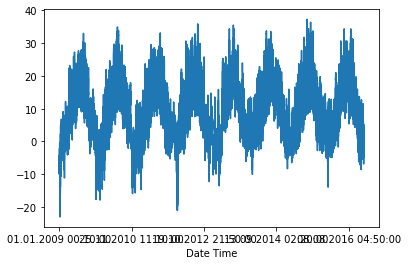

In [6]:
uni_data.plot()

In [7]:
uni_data = uni_data.values

In [8]:
## divisão de teste  para média de janela móvel de série temporal simples
train_split = 300000
tf.random.set_seed(13)

In [9]:
### padronizar dados
uni_data_mean = uni_data[:train_split].mean()
uni_data_std = uni_data[:train_split].std()
uni_data  = (uni_data - uni_data_mean)/ uni_data_std

print(type(uni_data))

<class 'numpy.ndarray'>


In [10]:
## funções de utilidade

## função para criar dados para previsão univariada

def univariate_data(dataset, start_idx , end_idx , history_size, target_size):
  data = []
  labels = []
  start_idx  = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx):
    idxs = range(i-history_size , i)
    data.append(np.reshape(dataset[idxs] , (history_size, 1))) ### remodelar dados
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

uni_data_history = 20   ## últimos 20 valores
uni_data_future = 0     ## dados futuros

x_train_uni , y_train_uni = univariate_data(uni_data , 0 , train_split , uni_data_history , uni_data_future)

x_val_uni , y_val_uni = univariate_data(uni_data , train_split , None ,uni_data_history , uni_data_future)

In [11]:
print(x_train_uni.shape , y_train_uni.shape)
print(x_val_uni.shape , y_val_uni.shape)

(299980, 20, 1) (299980,)
(120531, 20, 1) (120531,)


In [12]:
print('Janela única de dados do histórico' , x_train_uni[0])

print('Temperatura alvo a prever ' , y_train_uni[0])

Janela única de dados do histórico [[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]
Temperatura alvo a prever  -2.1041848598100876


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

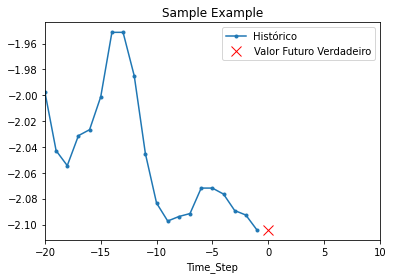

In [13]:
### função para criar passos de tempo
def create_time_steps(length):
  return list(range(-length,0))

### função para plotar dados de séries temporais

def plot_time_series(plot_data, delta , title):
  labels = ["Histórico" , 'Valor Futuro Verdadeiro' , 'Valor Predito Pelo Modelo']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt

plot_time_series([x_train_uni[0] , y_train_uni[0]] , 0 , 'Sample Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

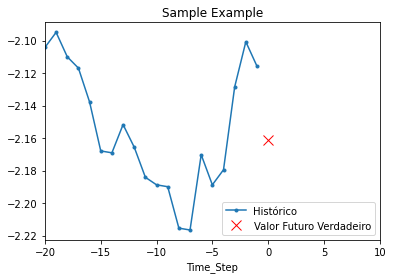

In [14]:
i = 20
plot_time_series([x_train_uni[i], y_train_uni[i]] , 0 , 'Sample Example')

In [15]:
### Média da janela móvel(MWA)

def MWA(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

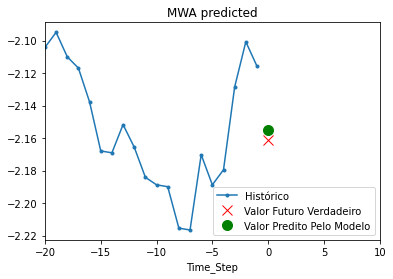

In [16]:
i = 20
plot_time_series([x_train_uni[i] , y_train_uni[i] , MWA(x_train_uni[i])] , 0 , 'MWA predicted')

In [17]:
## preparar o conjunto de dados do tensorflow
batch_size = 256
buffer_size = 10000

train_uni = tf.data.Dataset.from_tensor_slices((x_train_uni , y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni = tf.data.Dataset.from_tensor_slices((x_val_uni , y_val_uni))
val_uni = val_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_uni)
print(val_uni)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [18]:
## Definir o modelo LSTM  

lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(32 , input_shape = x_train_uni.shape[-2:]),
                                         tf.keras.layers.Dense(8, activation='relu'), 
                                         tf.keras.layers.Dense(1)])

lstm_model.compile(optimizer = 'adam', loss = 'mae')

steps = 200

EPOCHS =10

history= lstm_model.fit(train_uni , epochs = EPOCHS, steps_per_epoch = steps ,
               validation_data = val_uni, validation_steps = 50)

Epoch 1/10
200/200 [==============================] - 10s 8ms/step - loss: 0.2082 - val_loss: 0.0280
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0317 - val_loss: 0.0204
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0272 - val_loss: 0.0192
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0248 - val_loss: 0.0186
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0214 - val_loss: 0.0172
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0222 - val_loss: 0.0160
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0216 - val_loss: 0.0155
Epoch 8/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0201 - val_loss: 0.0139
Epoch 9/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0193 - val_loss: 0.0132
Epoch 10/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0177 - val_loss: 0.012

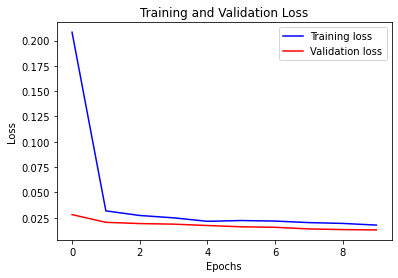

Final val loss:  [0.028029095381498337, 0.02038007415831089, 0.01917438954114914, 0.018595637753605843, 0.017243310809135437, 0.015993067994713783, 0.015481228940188885, 0.013893473893404007, 0.013215127401053905, 0.012892484664916992]


In [19]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print("Final val loss: ", val_loss)

visualize_loss(history, "Training and Validation Loss")

In [20]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,625
Trainable params: 4,625
Non-trainable params: 0
_________________________________________________________________


In [21]:
#instalando keras-sequential-ascii
!pip install keras_sequential_ascii

  Created wheel for keras-sequential-ascii: filename=keras_sequential_ascii-0.1.1-py3-none-any.whl size=3063 sha256=85ddd6cd7455e8128f403fce29c893148ae29c9ff9afcceb27ee168602034f3a
  Stored in directory: /root/.cache/pip/wheels/4e/99/75/8910ced4b40e8c20088c237fa706b32ac758321482ae2659e3
Successfully built keras-sequential-ascii


In [22]:
#Sumário Sequencial
from keras_sequential_ascii import keras2ascii
keras2ascii(lstm_model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     20    1
                LSTM   LLLLL -------------------      4352    94.1%
                tanh   #####          32
               Dense   XXXXX -------------------       264     5.7%
                relu   #####           8
               Dense   XXXXX -------------------         9     0.2%
                       #####           1


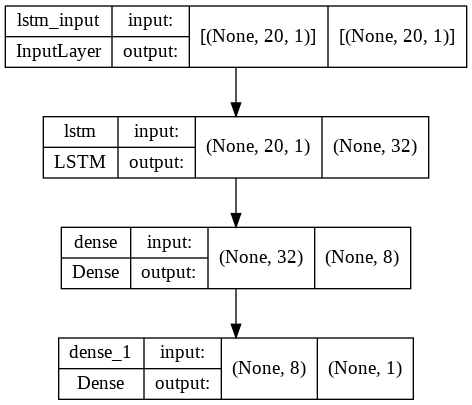

In [23]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(lstm_model, to_file=dot_img_file, show_shapes=True)

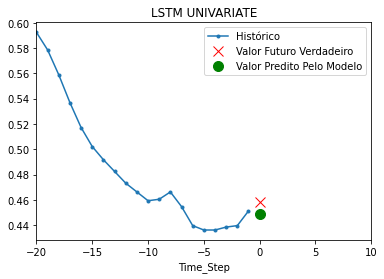

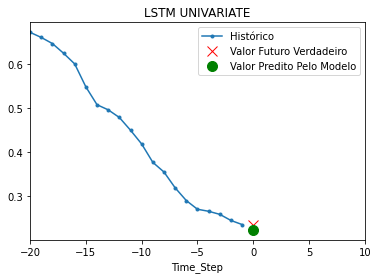

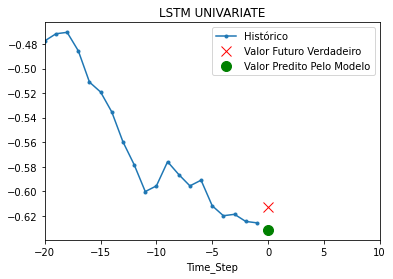

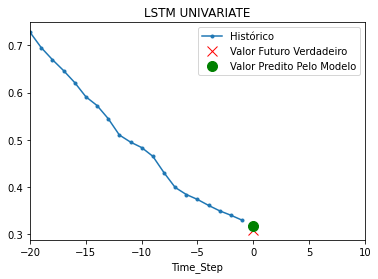

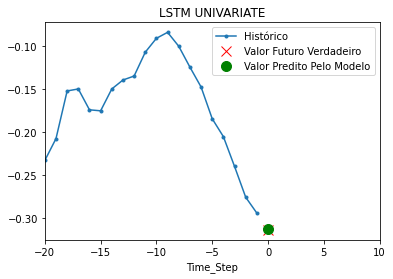

In [24]:
#algumas previsões de valores de serie temporal
for i , j in val_uni.take(5):
  plot = plot_time_series([i[0].numpy() , j[0].numpy() , lstm_model.predict(i)[0]] ,0 , 'LSTM UNIVARIATE')
  plot.show()

In [25]:
lstm_model.save('kerasmodeluni.h5') 

# gera binario do modelo keras

In [43]:
MODEL_TFLITE = '/content/kerasmodeluni.h5'
MODEL_TFLITE_MICRO = '/content/binariokerash5.cc'

In [44]:
#gerar modelo para microcontrolador

# Instale xxd se não estiver disponível
!apt-get update && apt-get -qq install xxd
# Converter para um arquivo de origem C, ou seja, um modelo TensorFlow Lite for Microcontrollers
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Atualizar nomes de variáveis
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [45]:
# Imprima o arquivo de origem C
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x89, 0x48, 0x44, 0x46, 0x0d, 0x0a, 0x1a, 0x0a, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x08, 0x08, 0x00, 0x04, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0xff, 0xff, 0xff, 0xff,
  0xff, 0xff, 0xff, 0xff, 0x90, 0x68, 0x01, 0x00, 0x00, 0x00, 0x00, 0x00,
  0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x60, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x88, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0xa8, 0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x07, 0x00, 0x01, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x10, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x20, 0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x68, 0x01, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x54, 0x52, 0x45, 0x45, 0x00, 0x00, 0x01, 0x00,
  0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff,
  0xff, 0x


**Quantização Apenas inteiro: ativações de 16 bits com pesos de 8 bits** :
Este é um esquema de quantização experimental. É semelhante ao esquema "somente inteiro", mas as ativações são quantizadas com base em seu intervalo de 16 bits, os pesos são quantizados em inteiros de 8 bits e a polarização é quantizada em inteiros de 64 bits. Isso é conhecido como quantização 16x8 adicional.

A principal vantagem dessa quantização é que ela pode melhorar a precisão significativamente, mas apenas aumentar ligeiramente o tamanho do modelo.

In [29]:
#converter para TensorflowLite
# Converte the model to the TensorFlow Lite normal (sem quantização)
#converte em tflite
converter = tf.lite.TFLiteConverter.from_keras_model(lstm_model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
modeltflite = converter.convert()

with open('modeltflite.tflite', 'wb') as f:
  f.write(modeltflite)

INFO:tensorflow:Assets written to: /tmp/tmpdgtbhd7t/assets


INFO:tensorflow:Assets written to: /tmp/tmpdgtbhd7t/assets


In [30]:
MODEL_TFLITE = '/content/modeltflite.tflite'
MODEL_TFLITE_MICRO = '/content/binariotflite.cc'

In [31]:
#gerar modelo para microcontrolador

# Instale xxd se não estiver disponível
!apt-get update && apt-get -qq install xxd
# Converter para um arquivo de origem C, ou seja, um modelo TensorFlow Lite for Microcontrollers
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Atualizar nomes de variáveis
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

In [32]:
# Imprima o arquivo de origem C
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x00, 0x00, 0x60, 0x00, 0x00, 0x00, 0x6c, 0x02, 0x00, 0x00,
  0x68, 0x00, 0x00, 0x00, 0x1c, 0x02, 0x00, 0x00, 0x98, 0x01, 0x00, 0x00,
  0x12, 0x00, 0x00, 0x00, 0x50, 0x61, 0x00, 0x00, 0xa8, 0x60, 0x00, 0x00,
  0xf0, 0x5f, 0x00, 0x00, 0x48, 0x5f, 0x00, 0x00, 0xb8, 0x5e, 0x00, 0x00,
  0xcc, 0x5d, 0x00, 0x00, 0xa0, 0x5c, 0x00, 0x00, 0x34, 0x5b, 0x00, 0x00,
  0xd8, 0x59, 0x00, 0x00, 0x7c, 0x58, 0x00, 0x00, 0xfc, 0x54, 0x00, 0x00,
  0x6c, 0x0d, 0x00, 0x00, 0xcc, 0x0b, 0x00, 0x00, 0x08, 0x09, 0x00, 0x00,
  0x6c, 0x08, 0x00, 0x00, 0x8c, 0x07, 0x00, 0x00, 0x9c, 0x06, 0x00, 0x00,
  0xe4, 0x03, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x9c, 0x56, 0x00, 0x00,
  0x38, 0x54, 0x00, 0x00, 0x18, 0x02, 0x00, 0x00, 0x4d, 0x00, 0x00, 0x00,
  0x90, 0x

In [33]:
# salva no modo Tensorflow (pb)
lstm_model.save('modelTF.tf')

INFO:tensorflow:Assets written to: modelTF.tf/assets


INFO:tensorflow:Assets written to: modelTF.tf/assets


In [34]:
MODEL_TFLITE = '/content/modelTF.tf/saved_model.pb'
MODEL_TFLITE_MICRO = '/content/binariotf.cc'

In [35]:
#gerar modelo para microcontrolador

# Instale xxd se não estiver disponível
!apt-get update && apt-get -qq install xxd
# Converter para um arquivo de origem C, ou seja, um modelo TensorFlow Lite for Microcontrollers
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Atualizar nomes de variáveis
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

In [36]:
# Imprima o arquivo de origem C
!cat {MODEL_TFLITE_MICRO}

A saída de streaming foi truncada nas últimas 5000 linhas.
  0x06, 0x3a, 0x04, 0x12, 0x02, 0x08, 0x20, 0x1a, 0x6d, 0x0a, 0x1c, 0x67,
  0x72, 0x61, 0x64, 0x69, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x52, 0x65, 0x73,
  0x68, 0x61, 0x70, 0x65, 0x5f, 0x67, 0x72, 0x61, 0x64, 0x2f, 0x53, 0x68,
  0x61, 0x70, 0x65, 0x12, 0x05, 0x43, 0x6f, 0x6e, 0x73, 0x74, 0x2a, 0x1a,
  0x0a, 0x0e, 0x5f, 0x6f, 0x75, 0x74, 0x70, 0x75, 0x74, 0x5f, 0x73, 0x68,
  0x61, 0x70, 0x65, 0x73, 0x12, 0x08, 0x0a, 0x06, 0x3a, 0x04, 0x12, 0x02,
  0x08, 0x02, 0x2a, 0x0b, 0x0a, 0x05, 0x64, 0x74, 0x79, 0x70, 0x65, 0x12,
  0x02, 0x30, 0x03, 0x2a, 0x1d, 0x0a, 0x05, 0x76, 0x61, 0x6c, 0x75, 0x65,
  0x12, 0x14, 0x42, 0x12, 0x08, 0x03, 0x12, 0x04, 0x12, 0x02, 0x08, 0x02,
  0x22, 0x08, 0x20, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x1a, 0xa1,
  0x01, 0x0a, 0x1e, 0x67, 0x72, 0x61, 0x64, 0x69, 0x65, 0x6e, 0x74, 0x73,
  0x2f, 0x52, 0x65, 0x73, 0x68, 0x61, 0x70, 0x65, 0x5f, 0x67, 0x72, 0x61,
  0x64, 0x2f, 0x52, 0x65, 0x73, 0x68, 0x61, 0x70, 0x6

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [37]:
# Atualiza a forma de entrada do modelo para um tamanho fixo de 8 bits, conforme ditado pelos requisitos de modelos de microcontroladores
batch_size = 1
lstm_model.input.set_shape((batch_size,) + lstm_model.input.shape[1:])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,625
Trainable params: 4,625
Non-trainable params: 0
_________________________________________________________________


**Quantização de faixa dinâmica** :
A forma mais simples de quantização pós-treinamento quantiza estaticamente apenas os pesos do ponto flutuante ao inteiro, que tem 8 bits de precisão:

In [38]:
# Converte o modelo para TensorFlow Lite  com quantizatização
converter = tf.lite.TFLiteConverter.from_keras_model(lstm_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflitemodoquant = converter.convert()
# Save the model to disk
open("tflitemodoquant.tflite", "wb").write(tflitemodoquant)

INFO:tensorflow:Assets written to: /tmp/tmpxlzvdd86/assets


INFO:tensorflow:Assets written to: /tmp/tmpxlzvdd86/assets


10272

In [39]:
MODEL_TFLITE = '/content/tflitemodoquant.tflite'
MODEL_TFLITE_MICRO = '/content/binariotflitequant.cc'

In [40]:
#gerar modelo para microcontrolador

# Instale xxd se não estiver disponível
!apt-get update && apt-get -qq install xxd
# Converter para um arquivo de origem C, ou seja, um modelo TensorFlow Lite for Microcontrollers
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Atualizar nomes de variáveis
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [41]:
# Imprima o arquivo de origem C
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00,
  0x14, 0x00, 0x00, 0x00, 0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x90, 0x27, 0x00, 0x00, 0x8c, 0x1c, 0x00, 0x00,
  0x74, 0x1c, 0x00, 0x00, 0xac, 0x00, 0x00, 0x00, 0x74, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x3a, 0xe1, 0xff, 0xff, 0x40, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
  0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xc0, 0xff, 0xff, 0xff,
  0x08, 0x00, 0x00, 0x00, 0x19, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00, 0x00,
  0x64, 0x65, 0x6e, 0x73, 0x65, 0x5f, 0x31, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x26, 0xe4, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00,
  0x0a, 0x

#Comparação tamanho dos modelos

In [42]:
keras_model_size = os.path.getsize("/content/kerasmodeluni.h5")
print("O modelo keras tem %d bytes" % keras_model_size)
tflite_model_size = os.path.getsize("/content/modeltflite.tflite")
print("O modelo  tensorflow lite tem %d bytes" % tflite_model_size)
quant_model_size = os.path.getsize("/content/tflitemodoquant.tflite")
print("O modelo quantizado tem %d bytes" % quant_model_size)
#difference = basic_model_size - quantized_model_size
#print("Difference is %d bytes" % difference)

O modelo keras tem 92304 bytes
O modelo  tensorflow lite tem 28208 bytes
O modelo quantizado tem 10272 bytes
